#**Determinación del número óptimo de clusters a través del Criterio de Información de Akaike (AIC) y el Criterio de Información Bayesiano(BIC)**
---

En este notebook se presenta el procedimiento para determinar el número óptimo de componentes para Gaussian Mixture Model, para la contrucción del vocabulario visual de Bag of Visual Words.







## **1. Instalación de librerías para el funcionamiento de este Notebook en Google Colab**

In [ ]:
#1. Librerías para autenticación cuenta de google drive
!pip install -U -q PyDrive
#2. Librería para leer base de datos
! python -m pip install "dask[complete]"

## **2. Importación de librerías**

In [ ]:
# 1. Autenticación y creación the PyDrive client
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# 2.Ejecuta esta celda para activar Google Drive.
from google.colab import drive as d
d.mount('/content/drive')

In [ ]:
# 3. Librerías para ejecutar el entrenamiento del modelo GMM
import os
import h5py
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import dask.dataframe as dd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn import svm
from sklearn import mixture 
from joblib import dump, load
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
"""Se especifica la dirección del área de trabajo"""
os.chdir('/content/drive/My Drive/DocLayoutEPN')

"""Se especifica una dirección para procesos temporales"""
temp_dir = '/content'

##**3. Cargar base de datos de momentos de Zernike  al espacio de trabajo**


---

Los momentos de Zernike estan almacenados en archivos de extensión ".csv" comprimidos en formato ".zip".

Se tiene 4 base de datos distintas almacenados con los siguientes nombres:


*   pool1.zip
*   pool3.zip
*   pool5.zip
*   pool7.zip










A continuación se descomprime de la base de datos pool3.zip

In [ ]:
number_pool = 3
path_zernike_moments = os.path.join('Database/ZernikeSymbols','pool'+str(number_pool)+'.zip')
! unzip -q {path_zernike_moments} -d{temp_dir}

### **3.1 Metadata**

---

La metadata contiene información sobre las regiones
 de donde provienen los símbolos a los cuales se ha extraído los momentos de Zernike. Esta información esta almacenada en un archivo de formato ".csv" con el nombre de "MetadataSymbols.csv".


In [ ]:
"""Se carga metadata con la librería Pandas"""
list_pool =  list(map(lambda x:x[:-4],os.listdir(temp_dir + '/pool'+str(number_pool))))
df  = pd.read_csv('Database/MetadataSymbols.csv')
DF = df[df['Identifier'].isin(list_pool)]


"""Se muestra la información de 10 regiones seleccionadas aletoriamente de la
   base de datos pool3.zip"""
DF.head(10).loc[:,'CoodX':'Identifier']

,CoodX,CoodY,Width,Height,Class,Number_page,Height_Page,Width_Page,Folder,Page,Identifier
34232,2183,2535,1710,262,equation,page2.png,5500,4250,pdf1293,page2.png,reg114831
34233,2183,1938,1710,69,equation,page2.png,5500,4250,pdf1293,page2.png,reg114832
34234,2183,1399,1710,271,equation,page2.png,5500,4250,pdf1293,page2.png,reg114833
34235,356,1351,1710,283,equation,page2.png,5500,4250,pdf1293,page2.png,reg114834
34236,2183,420,1710,775,equation,page2.png,5500,4250,pdf1293,page2.png,reg114835
34237,2183,4065,1817,540,equation,page4.png,5500,4250,pdf1293,page3.png,reg114844
34238,356,3982,1818,548,equation,page4.png,5500,4250,pdf1293,page3.png,reg114845
34239,2183,3540,1810,253,equation,page4.png,5500,4250,pdf1293,page3.png,reg114846
34240,356,2848,1710,170,equation,page4.png,5500,4250,pdf1293,page3.png,reg114847
34241,356,2207,1724,199,equation,page4.png,5500,4250,pdf1293,page3.png,reg114848


La base de datos pool3.zip contiene las siguientes cantidades de regiones etiquetados como texto y ecuación

In [ ]:
DF['Class'].value_counts()

equation      18024
block_text    13514
Name: Class, dtype: int64

### **3.2 Momentos de Zernike de los símbolos**

---

De la base de datos se extrayeron los momentos de Zernike de la siguiente cantidad de  símbolos para entrenar a GMM:


*   668175 símbolos de texto
*   641418 símbolos de ecuación

La magnitud de los 12 momentos de Zernike se encuentran almacenados en archivos ".csv" con nombres correspondientes a los identificadores de regiones de donde provienen.



**3.2.1 Momentos de Zernike para símbolos de texto**



In [ ]:
"""Se carga en memoria la magnitud de los momentos de Zernike para símbolos de texto """
text_samples = 1500
Text_symbol_for_processing = DF[DF['Class'].isin(["block_text"])].sample(n=text_samples, random_state=89)
dir_pool_csv_text =  list(map(lambda x:temp_dir + '/pool'+ str(number_pool)+'/'+x+'.csv', Text_symbol_for_processing['Identifier']))
text_for_clustering = dd.read_csv(dir_pool_csv_text)
zernike_symbol_text = text_for_clustering.loc[:,'Z1':'Z12']
zernike_symbol_text['Class'] = 'text'

"""Se muestra la información de la magnitud de los momentos de Zernike de
    10 símbolos de texto seleccionadas aletoriamente de la
    base de datos pool3.zip"""
zernike_symbol_text.head(10)

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Class
0,0.31831,3.959112e-19,0.641884,0.155419,6.351859e-18,1.201250e-18,0.486679,0.471401,0.075525,5.111965e-18,9.664835e-18,1.664359e-19,text
1,0.31831,3.959112e-19,0.641884,0.155419,6.351859e-18,1.201250e-18,0.486679,0.471401,0.075525,5.111965e-18,9.664835e-18,1.664359e-19,text
2,0.31831,3.959112e-19,0.641884,0.155419,6.351859e-18,1.201250e-18,0.486679,0.471401,0.075525,5.111965e-18,9.664835e-18,1.664359e-19,text
3,0.31831,3.892322e-16,0.650296,0.151384,5.962788e-04,3.670477e-04,0.505195,0.466702,0.071816,1.190101e-03,5.899974e-04,5.237486e-04,text
4,0.31831,3.892322e-16,0.650296,0.151384,5.962788e-04,3.670477e-04,0.505195,0.466702,0.071816,1.190101e-03,5.899974e-04,5.237486e-04,text
5,0.31831,1.619879e-15,0.645290,0.118422,1.923636e-01,7.142160e-02,0.612984,0.266870,0.071755,4.509916e-01,8.139732e-02,6.567350e-02,text
6,0.31831,3.464328e-15,0.536552,0.182838,2.968128e-02,2.324476e-02,0.224295,0.499607,0.063845,6.049883e-02,4.097128e-02,2.715845e-02,text
7,0.31831,3.464328e-15,0.536552,0.182838,2.968128e-02,2.324476e-02,0.224295,0.499607,0.063845,6.049883e-02,4.097128e-02,2.715845e-02,text
8,0.31831,6.050242e-16,0.548890,0.089159,5.032538e-02,6.349893e-02,0.250426,0.185464,0.035740,1.248267e-01,1.523957e-01,6.444244e-02,text
9,0.31831,6.050242e-16,0.548890,0.089159,5.032538e-02,6.349893e-02,0.250426,0.185464,0.035740,1.248267e-01,1.523957e-01,6.444244e-02,text


**3.2.2 Momentos de Zernike para símbolos de ecuación**

In [ ]:
"""Se carga en memoria la magnitud de los momentos de Zernike para símbolos de ecuación"""
equation_samples = 5*text_samples
Eq_symbol_for_processing = DF[DF['Class'].isin(["equation"])].sample(n=equation_samples, random_state=127)
dir_pool_csv_eq =  list(map(lambda x:temp_dir + '/pool'+str(number_pool)+'/'+x+'.csv', Eq_symbol_for_processing['Identifier']))
eq_for_clustering = dd.read_csv(dir_pool_csv_eq)
zernike_symbol_eq = eq_for_clustering.loc[:,'Z1':'Z12']
zernike_symbol_eq['Class'] = 'equation'

"""Se muestra la información de la magnitud de los momentos de Zernike de
    10 símbolos matemáticos seleccionadas aletoriamente de la
    base de datos pool3.zip"""
zernike_symbol_eq.head(10)

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Class
0,0.31831,7.684019e-19,0.642210,0.155582,1.057973e-18,2.012333e-19,0.487772,0.472212,0.075790,7.457720e-18,1.842365e-18,2.513294e-19,equation
1,0.31831,7.684019e-19,0.642210,0.155582,1.057973e-18,2.012333e-19,0.487772,0.472212,0.075790,7.457720e-18,1.842365e-18,2.513294e-19,equation
2,0.31831,5.606905e-16,0.656443,0.147456,3.577279e-04,3.599230e-04,0.517690,0.460056,0.067959,1.157579e-03,6.778303e-04,4.921565e-04,equation
3,0.31831,5.606905e-16,0.656443,0.147456,3.577279e-04,3.599230e-04,0.517690,0.460056,0.067959,1.157579e-03,6.778303e-04,4.921565e-04,equation
4,0.31831,8.831335e-16,0.554937,0.132556,2.544446e-03,2.540472e-03,0.226396,0.358631,0.031481,7.456628e-03,6.743069e-03,2.260892e-03,equation
5,0.31831,1.668515e-15,0.488891,0.181321,9.134961e-02,5.517968e-02,0.150410,0.426515,0.068995,2.507808e-01,7.711180e-02,4.667691e-02,equation
6,0.31831,1.122927e-13,0.439602,0.049129,7.982326e-03,5.336623e-02,0.009212,0.077760,0.033817,7.447129e-03,8.984833e-02,1.405942e-02,equation
7,0.31831,3.464328e-15,0.536552,0.182838,2.968128e-02,2.324476e-02,0.224295,0.499607,0.063845,6.049883e-02,4.097128e-02,2.715845e-02,equation
8,0.31831,2.829193e-16,0.600964,0.013398,3.047912e-03,2.294719e-02,0.286930,0.031171,0.014739,6.876727e-03,7.142833e-02,6.841797e-03,equation
9,0.31831,3.464328e-15,0.536552,0.182838,2.968128e-02,2.324476e-02,0.224295,0.499607,0.063845,6.049883e-02,4.097128e-02,2.715845e-02,equation


**3.2.3 Preparación de conjunto de datos para entrenamiento y prueba**

Cantidad de símbolos a utilizar para entrenamiento y prueba

In [ ]:
main_database = dd.concat([zernike_symbol_text, zernike_symbol_eq])
main_database.Class.value_counts().compute()

text        487913
equation    484257
Name: Class, dtype: int64

División del conjunto de datos para entrenamiento y evaluación de métricas AIC Y BIC


*   60% para entrenamiento
*   40% para evaluación







In [ ]:
finaldd_matrix = main_database.to_dask_array().compute()
Zernike_moments = finaldd_matrix[:,2:12]
labels_Zernike_moments = finaldd_matrix[:,12] 
train_matrix, test_matrix, label_train, label_test = train_test_split(Zernike_moments,
                                                                      labels_Zernike_moments, 
                                                                      test_size=0.4, 
                                                                      random_state=560, 
                                                                      stratify=labels_Zernike_moments)

Se construye dos matrices para entrenamiento y evaluación con los momentos de Zernike de los símbolos de texto y ecuación.

La matriz final tiene las siguientes dimensiones:


*   **Número de filas:** Número de símbolos
*   **Número de columnas:** 10 magnitudes de los momentos de Zernike. Se ignoran los dos primeros momentos porque no brindan información ya que para todos los símbolos toman los mismos valores.







In [ ]:
print('Dimensiones de matriz para entrenamiento:', train_matrix.shape)
print('Dimensiones de matriz para evaluacióm:', test_matrix.shape)

Dimensiones de matriz para entrenamiento: (583302, 10)
Dimensiones de matriz para evaluacióm: (388868, 10)


##**4. Entrenamiento de GMM**

Debido a que se determinará el número óptimo de clusters o componentes, se evalúa los criterios AIC y BIC para varios modelos GMM con distinto número de componentes.

In [ ]:
"""Entrenamiento GMM considerando modelos con varios componentes y almacenamiento
   de cada modelo entrenado"""
n_components = np.arange(0, 608, 32)
n_components[0] = 8
for n_comp in n_components:
  model_n_cluster = GaussianMixture(n_comp, covariance_type='full', random_state=0).fit(train_matrix)
  dump(model_n_cluster, 'IsolatedEquation/OptimalNumberCluster/TrainingGMMSummary/model_'+str(n_comp)+'_cluster.joblib')

In [ ]:
""" Cálculo de los criterios de AIC y BIC sobre el conjunto de entrenamiento
    de prueba """

n_components = np.arange(0, 608, 32)
n_components[0] = 8
bic_values=[]
aic_values=[]
for n_comp in n_components:
  model_n_cluster = load('IsolatedEquation/OptimalNumberCluster/TrainingGMMSummary/model_'+str(n_comp)+'_cluster.joblib')
  bic_values.append(model_n_cluster.bic(test_matrix))
  aic_values.append(model_n_cluster.aic(test_matrix))

Se muestra la curvas de los valores de AIC y BIC 
para cada uno de los modelos considerados

Text(0, 0.5, 'Score')

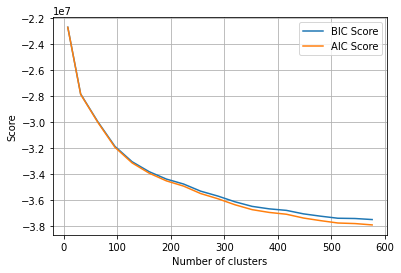

In [ ]:
plt.plot(n_components, bic_values, label='BIC Score')
plt.plot(n_components, aic_values, label='AIC Score')
plt.legend(loc='best')
plt.xlabel('Number of clusters')
plt.grid(True)
plt.ylabel('Score')